####  The code in this script can be used to replicate the publication figures from the decode pipeline output files (provided in https://drive.google.com/open?id=15YoTBTZh4MdtAqHbibkYieEqyLyFi5hb&usp=drive_fs)  and the Supplemental Data Files.

Most analysis required for replicating the figures is computed here. Data compiled elsewhere (e.g. abundances of tRNA ligases) and required for plots, is provided as a table in the google drive folder 2024_Tsour/pipeline_output/analysis_dependencies/.

A subset of analyses and figures that are not present here were generated in an independent script and can be accessed with other scripts in the repository, found in decode_analysis. These include Figure 2j; Figure 3b,c,e; Figure 4c,d,e; Figure 5a,b,c,d; Extndede Data Figure 3k; Extended Data Figure 4; Extended Data Figure 5a,c,f; Extended Data Figure 7; Extended Data Figure 8; Extended Data Figure 9b,c,d; Extended Data Figure 10a,b,c.

There is a lot of code in this script. It is organized and labeled by references to figures in the manuscript. It is recommended to find and run the analyses of interest, rather than running the entire script at once. E.g. search page for "Figure 3a" to find code to replicate that data.

###  The code in this notebook can be used to replicate:
    1. Figure 5
    2. Extended Data Figures 10

######  Panels 5a-d and Extended Data Figure 10a-c  are generated in https://github.com/SlavovLab/decode/tree/main/decode_analysis code
###### Panels 5e,f and Extended Data Figure 10d,e are generated in https://github.com/SlavovLab/decode/tree/main/gnomAD_analysis


#### Decode pipeline output files (provided in https://drive.google.com/drive/folders/15YoTBTZh4MdtAqHbibkYieEqyLyFi5hb?usp=sharing or generated by rerunning pipeline https://github.com/SlavovLab/decode/tree/main/decode_pipeline) required: 

    1. "Supplemental_Data_2.SAAP_proteins.xlsx"
    2. "Supplemental_Data_3.SAAP_precursor_quant.xlsx"
    3. "Supplemental_Data_4.SAAP_reporter_quant.xlsx"  
    4. "MTP_dict.p" (in pipeline_output/Mouse/AA_subs_pipeline)
    5. "DP_search_evidence_dict.p" (in pipeline_output/Mouse/AA_subs_pipeline)
    


*** It is highly recommended to maintain the same directory structure as in the Google Drive ***


The code in this notebook is organized and labeled by references to figures in the manuscript. It is recommended to find and run the analyses of interest, rather than running the entire script at once. E.g. search page for "Figure 2a" to find code to replicate that data.

In [11]:
# read in packages needed

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from collections import Counter
import scipy as sp
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import os
import ast
from scipy.odr import Model, RealData, ODR
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import milkviz as mv
from matplotlib_venn import venn3
import zipfile
from glob import glob
import gzip
import tarfile
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.collections import PatchCollection
import upsetplot as up
import itertools

#### Setting directories and reading in data.

All of these directories should be updated by the user to reflect where their output data from the decode pipeline st stored.


In [2]:
proj_dir = '/Users/shiri/Library/CloudStorage/GoogleDrive-tsour.s@husky.neu.edu/My Drive/MS/SuppData/2024_Tsour/'

ccrcc_proj_dir = proj_dir+'pipeline_output/CCRCC/'
ccrcc_aa_subs_dir = ccrcc_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
ccrcc_sample_map = pd.read_excel(ccrcc_aa_subs_dir+'sample_map.xlsx')
ccrcc_samples = ['S'+str(i) for i in list(set(ccrcc_sample_map['TMT plex']))]

ucec_proj_dir = proj_dir+'pipeline_output/UCEC/'
ucec_aa_subs_dir = ucec_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
ucec_sample_map = pd.read_excel(ucec_aa_subs_dir+'sample_map.xlsx')
ucec_samples = ['S'+str(i) for i in list(set(ucec_sample_map['TMT plex']))]

brca_proj_dir = proj_dir+'pipeline_output/BRCA/'
brca_aa_subs_dir = brca_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
brca_sample_map = pd.read_excel(brca_aa_subs_dir+'sample_map.xlsx')
brca_samples = ['S'+str(i) for i in list(set(brca_sample_map['TMT plex']))]

luad_proj_dir = proj_dir+'pipeline_output/LUAD/'
luad_aa_subs_dir = luad_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
luad_sample_map = pd.read_excel(luad_aa_subs_dir+'sample_map.xlsx')
luad_samples = ['S'+str(i) for i in list(set(luad_sample_map['TMT plex']))]

pdac_proj_dir = proj_dir+'pipeline_output/PDAC/'
pdac_aa_subs_dir = pdac_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
pdac_sample_map = pd.read_excel(pdac_aa_subs_dir+'sample_map.xlsx')
pdac_samples = ['S'+str(i) for i in list(set(pdac_sample_map['TMT plex']))]

lscc_proj_dir = proj_dir+'pipeline_output/LSCC/'
lscc_aa_subs_dir = lscc_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
lscc_sample_map = pd.read_excel(lscc_aa_subs_dir+'sample_map.xlsx')
lscc_samples = ['S'+str(i) for i in list(set(lscc_sample_map['TMT plex']))]

wang_proj_dir = proj_dir+'pipeline_output/HealthyTissues/'
wang_data_dir = wang_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
wang_samples = open(wang_data_dir+'proteomic_tissue_list.txt', 'r').read().split('\n')
wang_samples = [x for x in wang_samples if x!='rectum']

# lists used to quickly index dataset-specific sample maps (e.g.) from just the dataset name
datasets = ['CCRCC', 'UCEC', 'BRCA', 'LUAD', 'PDAC', 'LSCC', 'Healthy']
data_dir_list = [ccrcc_aa_subs_dir, ucec_aa_subs_dir, brca_aa_subs_dir, luad_aa_subs_dir, pdac_aa_subs_dir, lscc_aa_subs_dir, wang_data_dir]
samples_list = [ccrcc_samples, ucec_samples, brca_samples, luad_samples, pdac_samples, lscc_samples, wang_samples]
sample_map_list = [ccrcc_sample_map, ucec_sample_map, brca_sample_map, luad_sample_map, pdac_sample_map, lscc_sample_map]
proj_dir_list = [ccrcc_proj_dir, ucec_proj_dir, brca_proj_dir, luad_proj_dir, pdac_proj_dir, lscc_proj_dir, wang_proj_dir]

dependencies_dir = proj_dir+'pipeline_output/analysis_dependencies/'
outdir = 'figures_testing/' # output directory where to save figures

In [3]:
class GridShader():
    """
    function used to create alternating vertical gray and white background in plots
    """
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]], xticks, [xlim[-1]]]))

        start = [x-0.5 for x in locs[1-int(self.sf)::2]]
        end = [x-0.5 for x in locs[2-int(self.sf)::2]]

        for s, e in zip(start, end):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, **self.kw))


def bihist(y1, y2, nbins=10, h=None):
    '''
    Function used to create violin plots as bihistograms with no smoothing.
    h is an axis handle. If not present, a new figure is created.
    '''
    if h is None: h = plt.figure().add_subplot(111)
    ymin = np.floor(np.minimum(min(y1), min(y2)))
    ymax = np.ceil(np.maximum(max(y1), max(y2)))
    bins = np.linspace(ymin, ymax, nbins)
    n1, bins1, patch1 = h.hist(y1, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    n2, bins2, patch2 = h.hist(y2, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    # set xmax:
    xmax = 0
    for i in patch1:
        i.set_edgecolor(None)
        width = i.get_width()
        if width > xmax: xmax = width
    # invert second histogram and set xmin:
    xmin = 0
    for i in patch2:
        i.set_edgecolor(None)
        width = i.get_width()
        width = -width
        i.set_width(width)
        if width < xmin: xmin = width
    h.set_xlim(xmin*1.1, xmax*1.1)          
    h.figure.canvas.draw()

# Figure 5: Conservation of SAAP to mouse tissues

#### Incl. Extended Data Figure 10

In [4]:
# data needed for all analyses

filt_saap_df = pd.read_excel(proj_dir+'Supplemental_Data_2.SAAP_proteins.xlsx', index_col=0)
filt_prec_quant_df = pd.read_excel(proj_dir+'Supplemental_Data_3.SAAP_precursor_quant.xlsx', index_col=0)
filt_reporter_quant_df = pd.read_excel(proj_dir+'Supplemental_Data_4.SAAP_reporter_quant.xlsx', index_col=0)

# custom colormap
# this colormap is used for all RAAS dotplots 

import matplotlib
from matplotlib.cm import get_cmap
inferno_cmap = get_cmap('inferno')
viridis_cmap = get_cmap('viridis')

inferno_colors = inferno_cmap.colors
viridis_colors = viridis_cmap.colors

inferno_colors[-1] = viridis_colors[-1]
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", inferno_colors)

### Extended Data Figure 10f. Upset plot of intersection of mouse and human SAAP

In [6]:
def get_ds(saap, bp, filt_saap_df):
    """ function to get the list of datasets a given SAAP-BP pair is found in"""
    saap_bp_df = filt_saap_df.loc[(filt_saap_df['SAAP']==saap) & (filt_saap_df['BP']==bp)]
    ds_list = saap_bp_df['Dataset'].tolist()
    return(ds_list)

In [9]:
mouse_dir = proj_dir+'pipeline_output/Mouse/'
mtp_dict = pickle.load(open(mouse_dir+'AA_subs_pipeline/MTP_dict.p', 'rb'))

# get list of SAAP identified in mouse data 
samples = list(mtp_dict.keys())
all_mouse_saap = [x for y in [list(mtp_dict[s]['mistranslated sequence'].values()) for s in samples] for x in y]
all_mouse_saap = list(set([x for y in all_mouse_saap for x in y]))

# get list of SAAP identified in CPTAC/human label-free data
filt_saap_peptides = list(set(filt_saap_df['SAAP'].to_list()))

# Add list of datasets each saap is found in to filt_saap_df (Supplemental_Data_2). 
# Was also computed above in analysis for Extended 3e.
# get_ds fxn defined above
filt_saap_df['Datasets'] = filt_saap_df.apply(lambda x: get_ds(x['SAAP'], x['BP'], filt_saap_df), axis=1)

# get intersection of mouse and human SAAP
filt_overlap = [x for x in filt_saap_peptides if x in all_mouse_saap]
overlap_saap_df = filt_saap_df.loc[filt_saap_df['SAAP'].isin(filt_overlap)]

# add mouse to list of datasets intersected SAAP is found in
ds_list_mouse = []
for i,row in overlap_saap_df.iterrows():
    ds_list = row['Datasets']
    ds_list.append('Mouse')
    ds_list_mouse.append(str(ds_list))
overlap_saap_df['Datasets_w_mouse'] = ds_list_mouse

/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


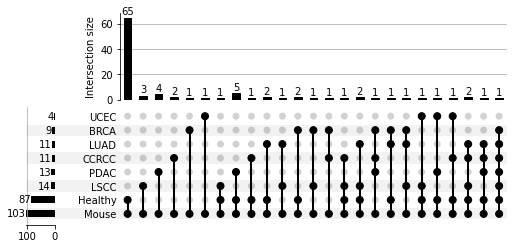

In [12]:
# prepare dataframe for upset plot
data4upset = []
data4upset_cols = ['SAAP','BP','Datasets']
saap_bp = [row['SAAP']+':'+row['BP'] for i,row in overlap_saap_df.iterrows()]
saap_bp = list(set(saap_bp))
for sb in saap_bp:
    saap = sb.split(':')[0]
    bp = sb.split(':')[1]
    overlap_rows = [i for i,row in overlap_saap_df.iterrows() if row['SAAP']==saap and row['BP']==bp]
    datasets = overlap_saap_df.loc[overlap_rows, 'Dataset'].to_list()
    datasets.append('Mouse')
    data4upset.append([saap, bp, str(datasets)])
upset_plot_df = pd.DataFrame(data4upset, columns=data4upset_cols)

# prepare index for upset plot
datasets = ['CCRCC','UCEC','BRCA','LUAD','PDAC','LSCC','Healthy', 'Mouse']
l = [False, True]
arrays = [list(i) for i in itertools.product(l, repeat=8)]
arrays = np.transpose(arrays)
tuples = list(zip(*arrays))
multiindex = pd.MultiIndex.from_tuples(tuples, names=datasets)

# format data and index into multiindex dataframe for upset plot
saap_counts = []
idx = multiindex[1]
keepidx = []
for idx in multiindex:
    if True in idx:
        saap_ds = [datasets[i] for i,x in enumerate(idx) if x==True]
        n_saap_ds = len(upset_plot_df.loc[upset_plot_df['Datasets']==str(saap_ds)])
        if n_saap_ds>0:
            saap_counts.append(n_saap_ds)
            keepidx.append(idx)  
keepidx = np.transpose(keepidx)
tuples = list(zip(*keepidx))
multiindex = pd.MultiIndex.from_tuples(tuples, names=datasets)
upset_plot_data = pd.Series(saap_counts, index=multiindex)

# plot upset plot
fig = plt.figure(figsize=(6,3))
up.plot(upset_plot_data, show_counts=True, fig=fig, element_size=20)
plt.savefig(outdir + 'Upsetplot_only_overlap.pdf', bbox_inches='tight')

### Figure 5g: Correlation of RAAS values for SAAP intersected between human and mouse data

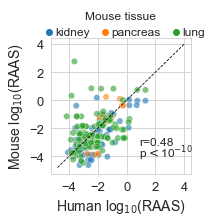

In [13]:
dp_ev_dict = pickle.load(open(mouse_dir+'AA_subs_pipeline/DP_search_evidence_dict.p','rb'))

# extract RAAS values for intersected SAAP into dataframe
plot_rows = []
plot_cols = ['Mouse tissue', 'SAAP', 'BP', 'SAAP intensity', 'BP intensity', 'Mouse RAAS', 'Human RAAS','Dataset']
for s in mtp_dict.keys():
    s_mtp = mtp_dict[s]
    s_ev = dp_ev_dict[s]
    for saap in filt_overlap:
        saap_keys = [k for k,v in s_mtp['mistranslated sequence'].items() if saap in v]
        saap_int = np.sum([s_mtp['Intensity'][k] for k in saap_keys])
        bps = [s_mtp['DP Base Sequence'][k] for k in saap_keys]
        for bp in bps:
            bp_int = s_ev.loc[s_ev['Sequence']==bp, 'Intensity'].sum()
            mouse_raas = np.log10(saap_int/bp_int)
            human_data = overlap_saap_df.loc[(overlap_saap_df['SAAP']==saap) & (overlap_saap_df['BP']==bp)]
            for i,row in human_data.iterrows():
                ds = row['Dataset']
                human_raas = row['Mean precursor RAAS']
                plot_rows.append([s, saap, bp, saap_int, bp_int, mouse_raas, human_raas, ds])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
plot_df.drop_duplicates(inplace=True)
plot_df.dropna(how='any', inplace=True)

# plot scatterplot of mouse vs human RAAS colored by tissue
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(2.5,2.5))
sns.scatterplot(data=plot_df, x='Human RAAS', y='Mouse RAAS', hue='Mouse tissue', alpha=0.6, s=40)
plt.legend(bbox_to_anchor=(0.5,1.1), fontsize=12, title='Mouse tissue', loc='center', 
           ncol=3, frameon=False, title_fontsize=12, handletextpad=-0.5, columnspacing=0.3)
ax.tick_params('both', labelsize=13)
plt.ylabel('Mouse log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('Human log$_{10}$(RAAS)', fontsize=14)

r,p = sp.stats.pearsonr(plot_df['Human RAAS'].values, plot_df['Mouse RAAS'].values)
ax.text(0.85, -3.2, 'r='+str(np.round(r,2)), fontsize=12)
ax.text(0.85,-4.1, 'p$<$10$^{-10}$', fontsize=12)
plt.plot((-4.8,4), (-4.8,4), '--k', linewidth=0.8)
plt.xlim(plt.ylim())
plt.xticks([-4,-2,0,2,4]);
plt.savefig('Mouse_human_RAAS_correlation_allPepquant.pdf', bbox_inches='tight')

### Figure 5h: ANOVA to attribute variance in RAAS to species, tissue type, and AAS type

In [14]:
# tissue type that each CPTAC dataset represents
cptac_tissue_dict = {'CCRCC':'kidney', 'PDAC':'pancreas', 'BRCA':'breast','UCEC':'endometrium','LSCC':'lung','LUAD':'lung'}

# prepare dataframe for ANOVA 
plot_rows = []
plot_cols = ['SAAP', 'BP', 'AAS', 'RAAS', 'Dataset', 'Tissue', 'Species','Dataset_type']
for s in mtp_dict.keys():
    s_mtp = mtp_dict[s]
    s_ev = dp_ev_dict[s]
    for saap in filt_overlap:
        saap_keys = [k for k,v in s_mtp['mistranslated sequence'].items() if saap in v]
        saap_int = np.sum([s_mtp['Intensity'][k] for k in saap_keys])
        bps = [s_mtp['DP Base Sequence'][k] for k in saap_keys]
        for bp in bps:
            bp_int = s_ev.loc[s_ev['Sequence']==bp, 'Intensity'].sum()
            mouse_raas = np.log10(saap_int/bp_int)
            mouse_tissue = s
            human_data = overlap_saap_df.loc[(overlap_saap_df['SAAP']==saap) & (overlap_saap_df['BP']==bp)]
            for i,row in human_data.iterrows():
                ds = row['Dataset']
                prec_df = filt_prec_quant_df.loc[(filt_prec_quant_df['Dataset']==ds) & (filt_prec_quant_df['SAAP']==saap) & (filt_prec_quant_df['BP']==bp)]
                for i,row in prec_df.iterrows():
                    raas = row['RAAS']
                    aas = row['AAS']
                    if ds=='Healthy':
                        tissue = row['TMT/Tissue']
                        ds_type = 'Label-free'
                    else:
                        tissue = cptac_tissue_dict[ds]
                        ds_type = 'TMT'
                    plot_rows.append([saap, bp, aas, raas, ds, tissue, 'Human', ds_type])
            plot_rows.append([saap, bp, aas, mouse_raas, 'Kuster_mouse', mouse_tissue, 'Mouse', 'Label-free'])
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

anova_df = plot_df
anova_df.replace(np.inf, np.nan, inplace=True)
anova_df.replace(-np.inf, np.nan, inplace=True)
anova_df.dropna(how='any', inplace=True)

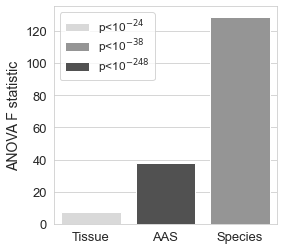

In [15]:
# generate ANOVA model with independent variables of interest and RAAS dependent variable
model = ols('RAAS ~ C(Tissue) + C(AAS) + C(Species)', data=anova_df).fit()
df = sm.stats.anova_lm(model, typ=3)
df.reset_index(inplace=True)
df.columns = ['Variable']+df.columns.to_list()[1:]

# generate dataframe with ANOVA results to plot 
plot_df = df.loc[1:3, ['Variable', 'F', 'PR(>F)']]
for i in plot_df.index:
    plot_df.loc[i,'PR(>F)'] = '{:0.0e}'.format(plot_df.loc[i,'PR(>F)'])
plot_df['Variable'] = ['Tissue','AAS','Species']
plot_df = plot_df.loc[[1,3,2],:]

# plot ANOVA results 
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(4,4))
sns.barplot(data=plot_df, x='Variable', y='F', hue='PR(>F)', dodge=False, palette='Greys',
           order=['Tissue', 'AAS', 'Species'])#, hue_order=['Species','Data type','Tissue','AAS'])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles = handles, labels = ['p<10$^{-24}$', 'p<10$^{-38}$', 'p<10$^{-248}$'],
           loc='upper left', fontsize=12, title_fontsize=13, labelspacing=0.1)
plt.xlabel('')
plt.ylabel('ANOVA F statistic', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.savefig('mouse_ANOVA_tissue_AAS_result.pdf', bbox_inches='tight')